In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import seaborn as sns

from fBM import fBM_analytic_pricer, fBM_MC_pricer, fBM_sigkernel_pricer
from utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
# model parameters
T, a         = 1., -0.4
n_increments = 10
grid = np.linspace(0, T, 1+n_increments)

# payoffs
payoff_type = 'identity'
# payoff_type = 'Exponential'
# payoff_type = 'Call'

nu = 2e-1
log_strike = -2
if payoff_type == 'identity':
    payoff = lambda x: x
if payoff_type == 'exponential': 
    payoff = lambda x: np.exp(nu*x) 
if payoff_type == 'call': 
    payoff = lambda x: max(x - log_strike, 0.) # call 

# evaluation points
n_eval       = 100
# t_inds_eval  = np.random.choice([n_increments], n_eval)
t_inds_eval  = np.random.choice(np.arange(n_increments), n_eval)
paths_eval   = generate_theta_paths(t_inds_eval, n_increments, T, a)

In [3]:
# for i in range(n_eval):
#     plt.plot(paths_eval[i,:,1], alpha=0.2, color='blue')
# plt.show()

In [4]:
true_prices = fBM_analytic_pricer(t_inds_eval, paths_eval, grid, a, T, nu, log_strike, payoff_type=payoff_type)

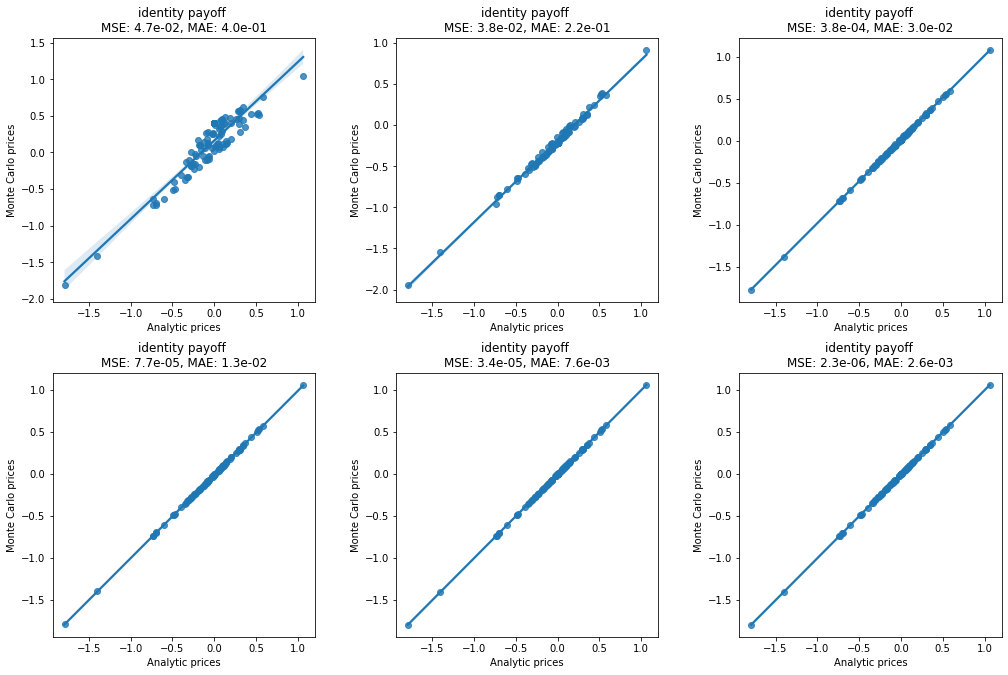

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))  # 2 rows, 3 columns
fig.tight_layout(pad=5.0)

idx = 0
for n_samples_mc in [10, 100, 1000, 10000, 20000, 30000]:
    mc_pricer = fBM_MC_pricer(n_increments, n_samples_mc, T, a)
    mc_prices = mc_pricer.fit_predict(t_inds_eval, paths_eval, payoff)

    mse_error = mse(true_prices, mc_prices)
    mae_error = mae(true_prices, mc_prices)

    row, col = divmod(idx, 3)  # get row and column index
    ax = axes[row, col]
    
    sns.regplot(x=true_prices, y=mc_prices, ax=ax)
    ax.set_xlabel('Analytic prices')
    ax.set_ylabel('Monte Carlo prices')
    
    # Display errors in scientific notation
    title_text = (f"{payoff_type} payoff \n"
                  f"MSE: {mse_error:.1e}, MAE: {mae_error:.1e}")
    
    ax.set_title(title_text)
    
    idx += 1
    
plt.show()

In [ ]:
m, n = 10, 10

sigmas_t   = [1e0, 5e0, 1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5, 5e5, 1e6]
sigmas_sig = sigmas_t

mse_score = 1e5
for sigma_t in tqdm(sigmas_t):
    for sigma_sig in sigmas_sig:

        sig_pricer = fBM_sigkernel_pricer(n_increments, m, n, T, a, sigma_t, np.array([sigma_sig]), sig_ds=1e-3, sig_dt=1e-3)
        sig_pricer.fit(payoff)
        sig_prices = sig_pricer.predict(t_inds_eval, paths_eval) 

        mse_score_pred = mse(true_prices, sig_prices)

        if mse_score_pred < mse_score: 
            print(f'sigma_t: {sigma_t}, sigma_sig: {sigma_sig}, MSE: {mse_score_pred}')
            mse_score = mse_score_pred
            sigma_t_best, sigma_sig_best = sigma_t, sigma_sig

  0%|          | 0/13 [00:00<?, ?it/s]

In [215]:
m, n = 200, 200
sigma_t_best, sigma_sig_best = 1e2, 1e5

In [216]:
sig_pricer = fBM_sigkernel_pricer(n_increments, m, n, T, a, sigma_t_best, sigma_sig_best, dyadic_order, max_batch, device)
sig_pricer.fit(payoff)
sig_prices = sig_pricer.predict(t_inds_eval, paths_eval)
r2_score  = r2(true_prices, sig_prices)
mse_error = mse(true_prices, sig_prices)
mae_error = mae(true_prices, sig_prices)

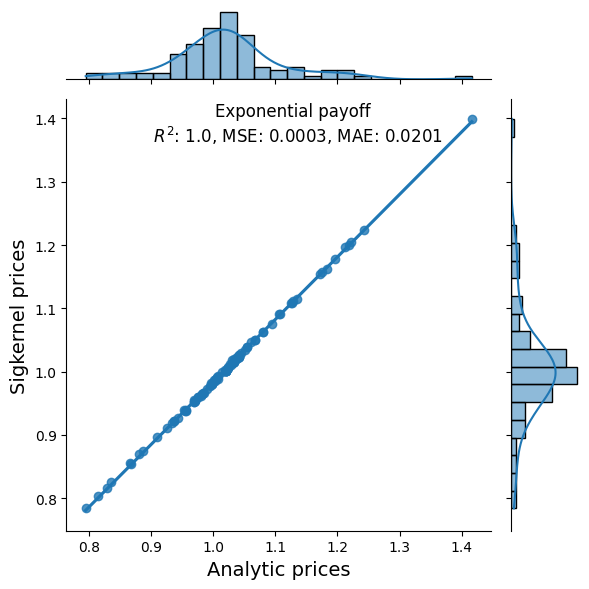

In [217]:
p = sns.jointplot(x=true_prices, y=sig_prices, kind='reg')
p.set_axis_labels('Analytic prices', 'Sigkernel prices', fontsize=14)
p.fig.suptitle(payoff_type + f" payoff \n $R^2$: {np.round(r2_score, 3)}, MSE: {np.round(mse_error, 4)}, MAE: {np.round(mae_error, 4)}", y = 0.82)
p.figure.tight_layout()
plt.savefig('figures/fBM_' + payoff_type)
plt.show()

In [197]:
# precisions = [1e-2, 1e-3, 1e-4, 5e-5, 2e-5]

# n_samples_mc, error_mc = 0, 1e9
# m, n, error_sig        = 0, 0, 1e9

# for precision in precisions:

#     # MC prices
#     while error_mc > precision:
#         n_samples_mc += 10
#         mc_pricer = fBM_MC_pricer(n_increments, n_samples_mc, T, a)
#         t0 = time.time()
#         mc_prices = mc_pricer.fit_predict(t_inds_eval, paths_eval, payoff)
#         t1 = time.time()
#         error_mc  = mse(mc_prices, true_prices)

#     print('Monte Carlo | %2.5f | sample paths: %r | time: %2.4f sec' % (precision, n_samples_mc, t1-t0))
    
#     # PPDE prices
#     while error_sig > precision:
#         m += 10
#         n += 10
#         # print(m,n)
#         sig_pricer = fBM_sigkernel_pricer(n_increments, m, n, T, a, sigma_t_best, sigma_sig_best, dyadic_order, max_batch, device)
#         sig_pricer.fit(payoff)
#         t0 = time.time()
#         sig_prices = sig_pricer.predict(t_inds_eval, paths_eval) 
#         t1 = time.time()
#         error_sig = mse(sig_prices, true_prices)
#         torch.cuda.empty_cache()

#     print('PPDE (sigkernel) | %2.5f | collocation points: (%r,%r) | time: %2.4f sec \n' % (precision, m, n, (t1-t0)/2))
